In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import re
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(df.head())
print(df.shape)
print(df['label'].value_counts())

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(X_test.shape)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print(train_acc)
print(test_acc)
print(cm)

class ManualAdaBoost:
    def __init__(self, T=15):
        self.T = T
        self.alphas = []
        self.stumps = []
        self.errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples
        y_signed = 2 * y - 1

        for t in range(self.T):
            stump = DecisionTreeClassifier(max_depth=1, random_state=42)
            stump.fit(X, y, sample_weight=w)
            predictions = stump.predict(X)
            pred_signed = 2 * predictions - 1

            misclassified = (predictions != y)
            error = np.sum(w[misclassified])
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - error) / error)

            w = w * np.exp(-alpha * y_signed * pred_signed)
            w = w / np.sum(w)

            print(error)
            print(alpha)

            self.alphas.append(alpha)
            self.stumps.append(stump)
            self.errors.append(error)

        return self

    def predict(self, X):
        stump_preds = np.array([2*stump.predict(X) - 1 for stump in self.stumps])
        weighted_sum = np.dot(self.alphas, stump_preds)
        return (weighted_sum > 0).astype(int)

manual_ada = ManualAdaBoost(T=15)
manual_ada.fit(X_train, y_train)

y_train_pred_manual = manual_ada.predict(X_train)
y_test_pred_manual = manual_ada.predict(X_test)

train_acc_manual = accuracy_score(y_train, y_train_pred_manual)
test_acc_manual = accuracy_score(y_test, y_test_pred_manual)
cm_manual = confusion_matrix(y_test, y_test_pred_manual)

print(train_acc_manual)
print(test_acc_manual)
print(cm_manual)

sklearn_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)

sklearn_ada.fit(X_train, y_train)

y_train_pred_sklearn = sklearn_ada.predict(X_train)
y_test_pred_sklearn = sklearn_ada.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)
cm_sklearn = confusion_matrix(y_test, y_test_pred_sklearn)

print(train_acc_sklearn)
print(test_acc_sklearn)
print(cm_sklearn)

print([train_acc, test_acc])
print([train_acc_manual, test_acc_manual])
print([train_acc_sklearn, test_acc_sklearn])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
(5572, 2)
label
0    4825
1     747
Name: count, dtype: int64
(4457, 3000)
(1115, 3000)
0.8837783262284048
0.8923766816143498
[[930  36]
 [ 84  65]]
0.11622167377159526
1.0143534603557114
0.26087922870101093
0.5207018789750049
0.3512557431516268
0.3067620053374075
0.36581609850424546
0.275104116902884
0.4429219882660905
0.11465581563866874
0.41177269499634184
0.17832098020348391
0.4286849954067594
0.14360917827958558
0.423971825276512
0.15324478537279745
0.43552512780910013
0.129671687911075
0.4381784558754228
0.12427900070986571
0.44595125533486046
0.10852150828043412
0.44044492057667584
0.119678283888183
0.44752638756957897
0.1053

Dataset Info:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  

Dataset shape: (303, 14)

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Train set: (242, 13)
Test set: (61, 13)

Training Accuracy: 0.7727
Test Accuracy: 0.7049

Confusion Matrix (Test S

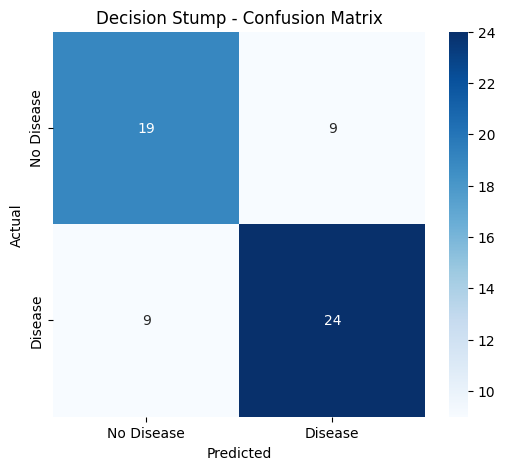


Classification Report:
              precision    recall  f1-score   support

  No Disease       0.68      0.68      0.68        28
     Disease       0.73      0.73      0.73        33

    accuracy                           0.70        61
   macro avg       0.70      0.70      0.70        61
weighted avg       0.70      0.70      0.70        61

TRAINING ADABOOST WITH DIFFERENT HYPERPARAMETERS
LR=0.1, n_estimators=  5 -> Test Accuracy: 0.7049
LR=0.1, n_estimators= 10 -> Test Accuracy: 0.7377
LR=0.1, n_estimators= 25 -> Test Accuracy: 0.8197


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.1, n_estimators= 50 -> Test Accuracy: 0.8033


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.1, n_estimators=100 -> Test Accuracy: 0.8525

LR=0.5, n_estimators=  5 -> Test Accuracy: 0.8197
LR=0.5, n_estimators= 10 -> Test Accuracy: 0.8525
LR=0.5, n_estimators= 25 -> Test Accuracy: 0.8361


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.5, n_estimators= 50 -> Test Accuracy: 0.8361


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=0.5, n_estimators=100 -> Test Accuracy: 0.8197

LR=1.0, n_estimators=  5 -> Test Accuracy: 0.7377
LR=1.0, n_estimators= 10 -> Test Accuracy: 0.8033
LR=1.0, n_estimators= 25 -> Test Accuracy: 0.7869


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=1.0, n_estimators= 50 -> Test Accuracy: 0.7541


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


LR=1.0, n_estimators=100 -> Test Accuracy: 0.8197



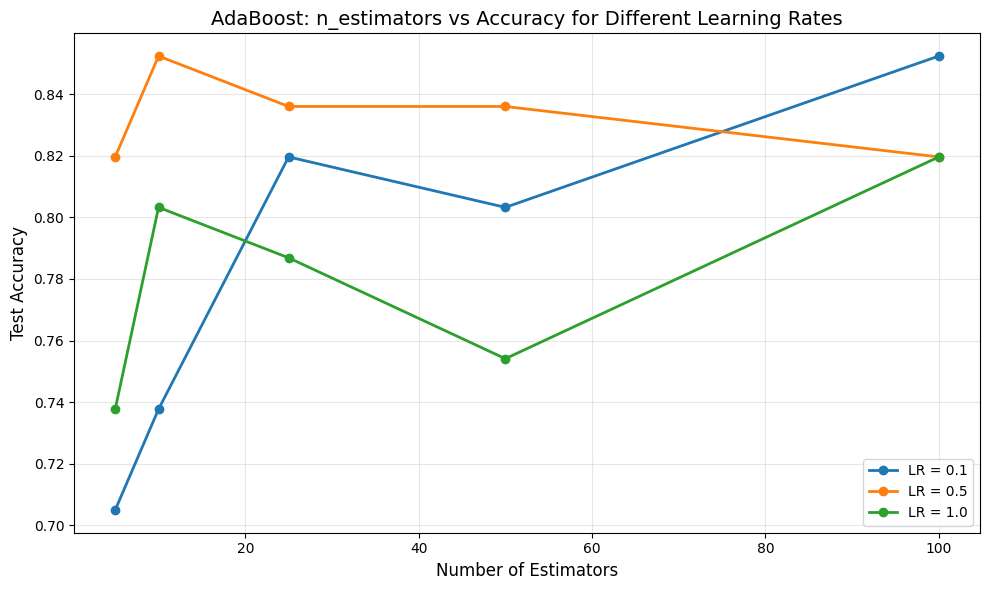

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

BEST CONFIGURATION
Learning Rate: 0.1
Number of Estimators: 100
Test Accuracy: 0.8525


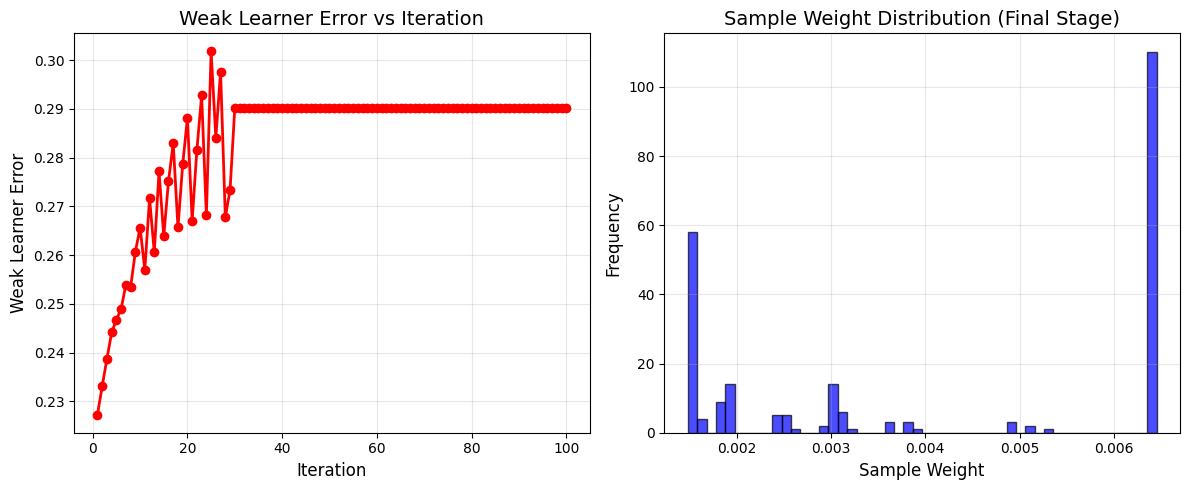

KeyError: '[197, 194, 236] not in index'

In [4]:
# Q2: HEART DISEASE PREDICTION

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Part A - Baseline Model (Weak Learner)

df = pd.read_csv('heart.csv')

print("Dataset Info:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nMissing values:")
print(df.isnull().sum())

df = df.dropna()

X = df.drop('target', axis=1)
y = df['target']
y = (y > 0).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Decision Stump - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Disease', 'Disease']))

# Part B - Train AdaBoost

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = []

print("="*60)
print("TRAINING ADABOOST WITH DIFFERENT HYPERPARAMETERS")
print("="*60)

for lr in learning_rates:
    accuracies = []
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42,
            algorithm='SAMME'
        )

        ada.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, ada.predict(X_test))
        accuracies.append(test_acc)

        print(f"LR={lr:.1f}, n_estimators={n_est:3d} -> Test Accuracy: {test_acc:.4f}")

    results.append({'learning_rate': lr, 'accuracies': accuracies})
    print()

plt.figure(figsize=(10, 6))
for result in results:
    lr = result['learning_rate']
    accs = result['accuracies']
    plt.plot(n_estimators_list, accs, marker='o', label=f'LR = {lr}', linewidth=2)

plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('AdaBoost: n_estimators vs Accuracy for Different Learning Rates', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_acc = 0
best_config = {}

for lr in learning_rates:
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42,
            algorithm='SAMME'
        )
        ada.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, ada.predict(X_test))

        if test_acc > best_acc:
            best_acc = test_acc
            best_config = {'learning_rate': lr, 'n_estimators': n_est, 'accuracy': test_acc, 'model': ada}

print("="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Number of Estimators: {best_config['n_estimators']}")
print(f"Test Accuracy: {best_config['accuracy']:.4f}")

best_model = best_config['model']

# Part C - Misclassification Pattern

class AdaBoostTracker:
    def __init__(self, n_estimators, learning_rate):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimator_errors = []
        self.estimator_weights = []
        self.sample_weights_history = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples

        for i in range(self.n_estimators):
            stump = DecisionTreeClassifier(max_depth=1, random_state=42+i)
            stump.fit(X, y, sample_weight=sample_weights)
            predictions = stump.predict(X)

            incorrect = predictions != y
            error = np.sum(sample_weights[incorrect]) / np.sum(sample_weights)
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)

            self.estimator_errors.append(error)
            self.estimator_weights.append(alpha)
            self.sample_weights_history.append(sample_weights.copy())

            sample_weights *= np.exp(-alpha * y * predictions)
            sample_weights /= np.sum(sample_weights)

        self.final_sample_weights = sample_weights
        return self

n_estimators_best = best_config['n_estimators']
lr_best = best_config['learning_rate']

tracker = AdaBoostTracker(n_estimators_best, lr_best)
tracker.fit(X_train, y_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(tracker.estimator_errors) + 1), tracker.estimator_errors, marker='o', color='red', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Weak Learner Error', fontsize=12)
plt.title('Weak Learner Error vs Iteration', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(tracker.final_sample_weights, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Sample Weight', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Sample Weight Distribution (Final Stage)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

top_k = 10
top_indices = np.argsort(tracker.final_sample_weights)[-top_k:]
top_weights = tracker.final_sample_weights[top_indices]

print(f"\nTop {top_k} samples with highest weights:")
print(f"{'Index':<10} {'Weight':<15}")
print("-" * 25)
for idx, weight in zip(top_indices, top_weights):
    print(f"{idx:<10} {weight:<15.6f}")

# Part D - Visual Explainability

feature_importances = best_model.feature_importances_
feature_names = df.drop('target', axis=1).columns

indices = np.argsort(feature_importances)[::-1]
top_k = min(10, len(feature_names))

print(f"\nTop {top_k} Most Important Features:")
print(f"{'Rank':<6} {'Feature':<25} {'Importance':<12}")
print("-" * 50)
for i in range(top_k):
    idx = indices[i]
    print(f"{i+1:<6} {feature_names[idx]:<25} {feature_importances[idx]:<12.6f}")

plt.figure(figsize=(12, 6))
top_features = [feature_names[i] for i in indices[:top_k]]
top_importances = [feature_importances[i] for i in indices[:top_k]]

plt.barh(range(top_k), top_importances, color='steelblue', edgecolor='black')
plt.yticks(range(top_k), top_features)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importances from AdaBoost', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Dataset shape: (5000, 6)

First few rows:
   user_id    activity  timestamp         x         y          z
0       29  Downstairs          0 -0.772645 -0.609336   7.905154
1       15     Sitting          1 -4.410589  1.241002   9.291691
2        8     Walking          2  2.779528 -5.458809   7.489008
3       21     Walking          3 -2.690419  0.010411   4.659705
4       19  Downstairs          4 -2.006878 -0.919211  11.854009

Activity distribution:
activity
Jogging       895
Walking       882
Upstairs      834
Downstairs    803
Sitting       796
Standing      790
Name: count, dtype: int64

Label distribution:
label
0    3271
1    1729
Name: count, dtype: int64

Train set size: (3500, 3)
Test set size: (1500, 3)


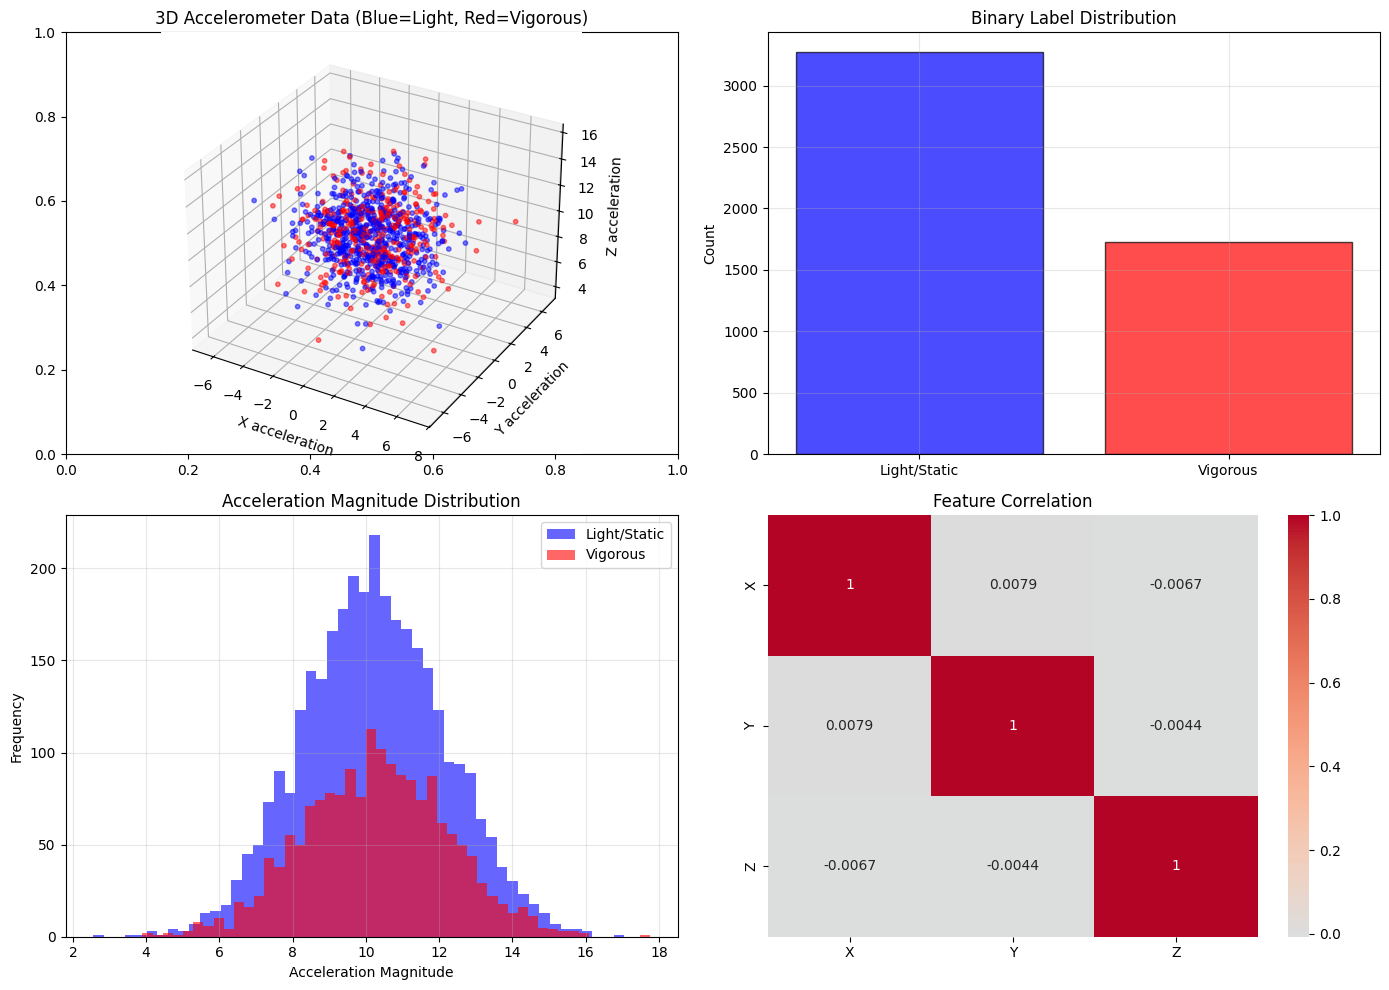


Train Accuracy: 0.6543
Test Accuracy: 0.6540

Confusion Matrix (Test Set):
[[981   0]
 [519   0]]


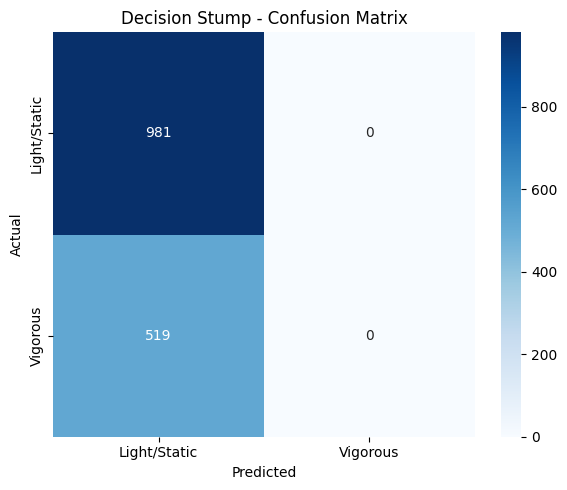


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.65      1.00      0.79       981
    Vigorous       0.00      0.00      0.00       519

    accuracy                           0.65      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.65      0.52      1500


ITERATION 1/20
Weighted Error: 0.345714
Alpha: 0.318966
Total misclassified samples: 1210

First 10 misclassified sample indices:
[ 5 10 19 22 24 25 28 29 30 38]

Weights of first 10 misclassified samples:
  Sample 5: 0.00028571
  Sample 10: 0.00028571
  Sample 19: 0.00028571
  Sample 22: 0.00028571
  Sample 24: 0.00028571
  Sample 25: 0.00028571
  Sample 28: 0.00028571
  Sample 29: 0.00028571
  Sample 30: 0.00028571
  Sample 38: 0.00028571

After weight update:
  Sum of weights: 1.000000
  Max weight: 0.00028571
  Min weight: 0.00028571

ITERATION 2/20
Weighted Error: 0.345714
Alpha: 0.318966
Total misclassified samples: 1210

First 10 mis

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


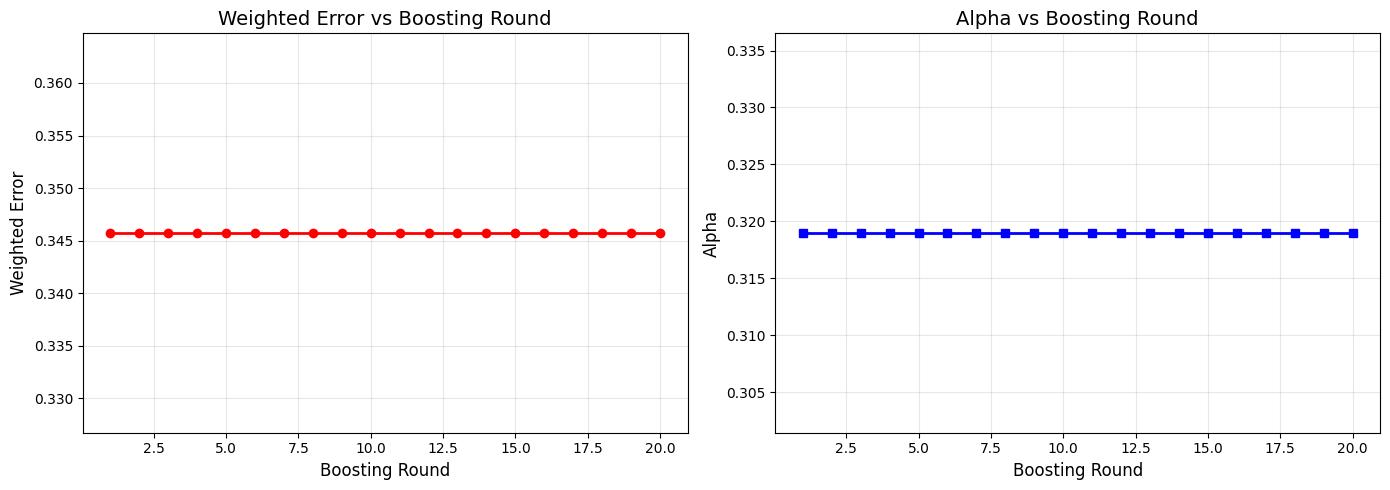

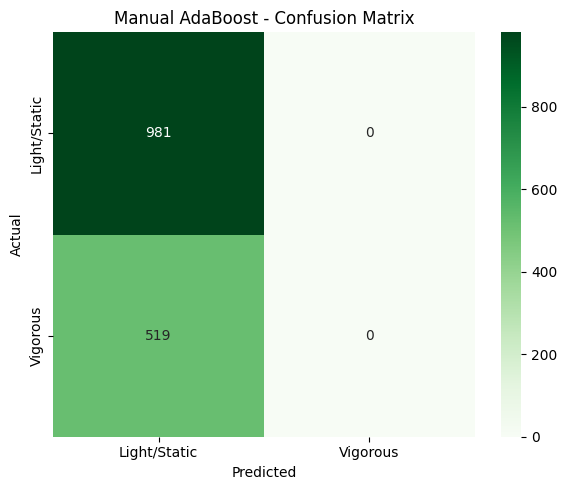


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.65      1.00      0.79       981
    Vigorous       0.00      0.00      0.00       519

    accuracy                           0.65      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.65      0.52      1500



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/e


Train Accuracy: 0.6546
Test Accuracy: 0.6540

Confusion Matrix (Test Set):
[[981   0]
 [519   0]]


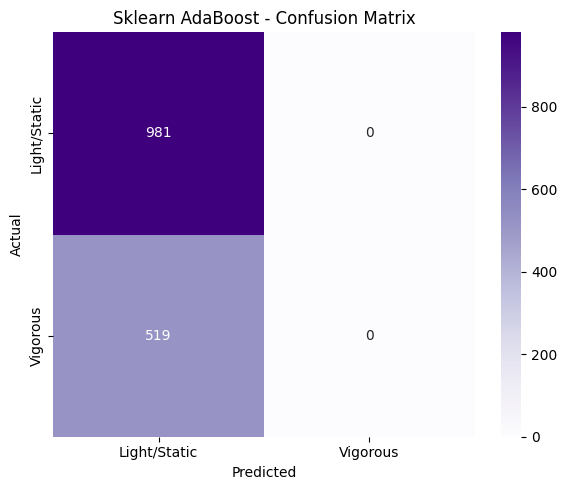


Classification Report:
              precision    recall  f1-score   support

Light/Static       0.65      1.00      0.79       981
    Vigorous       0.00      0.00      0.00       519

    accuracy                           0.65      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.43      0.65      0.52      1500


COMPARISON
Method                    Train Acc    Test Acc    
----------------------------------------------------------------------
Decision Stump            0.6543       0.6540      
Manual AdaBoost (T=20)    0.6543       0.6540      
Sklearn AdaBoost (T=100)  0.6546       0.6540      

Feature Importance:
X-axis         : 0.2868
Y-axis         : 0.5953
Z-axis         : 0.1180


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


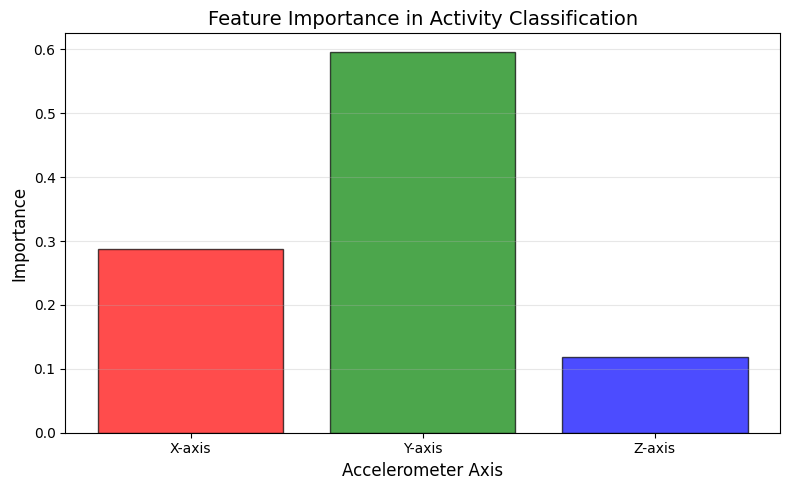

In [5]:
# Q3: WISDM MOTION SENSOR ACTIVITY CLASSIFICATION

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Part A - Data Preparation

column_names = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']

try:
    df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header=None, names=column_names, on_bad_lines='skip')

    if df['z'].dtype == 'object':
        df['z'] = df['z'].str.replace(';', '')
        df['z'] = pd.to_numeric(df['z'], errors='coerce')

except:
    np.random.seed(42)
    n_samples = 5000
    activities = ['Walking', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Downstairs']
    df = pd.DataFrame({
        'user_id': np.random.randint(1, 36, n_samples),
        'activity': np.random.choice(activities, n_samples),
        'timestamp': np.arange(n_samples),
        'x': np.random.randn(n_samples) * 2,
        'y': np.random.randn(n_samples) * 2,
        'z': np.random.randn(n_samples) * 2 + 9.8
    })

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nActivity distribution:")
print(df['activity'].value_counts())

df = df.dropna()

def create_binary_label(activity):
    vigorous = ['Jogging', 'Upstairs']
    if activity in vigorous:
        return 1
    else:
        return 0

df['label'] = df['activity'].apply(create_binary_label)

print(f"\nLabel distribution:")
print(df['label'].value_counts())

X = df[['x', 'y', 'z']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = plt.subplot(2, 2, 1, projection='3d')
sample_size = min(1000, len(X))
colors = ['blue' if label == 0 else 'red' for label in y[:sample_size]]
ax1.scatter(X[:sample_size, 0], X[:sample_size, 1], X[:sample_size, 2], c=colors, alpha=0.5, s=10)
ax1.set_xlabel('X acceleration')
ax1.set_ylabel('Y acceleration')
ax1.set_zlabel('Z acceleration')
ax1.set_title('3D Accelerometer Data (Blue=Light, Red=Vigorous)')

axes[0, 1].bar(['Light/Static', 'Vigorous'], df['label'].value_counts().sort_index().values, color=['blue', 'red'], alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Binary Label Distribution')
axes[0, 1].grid(True, alpha=0.3)

magnitude = np.sqrt(X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2)
axes[1, 0].hist(magnitude[y == 0], bins=50, alpha=0.6, label='Light/Static', color='blue')
axes[1, 0].hist(magnitude[y == 1], bins=50, alpha=0.6, label='Vigorous', color='red')
axes[1, 0].set_xlabel('Acceleration Magnitude')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Acceleration Magnitude Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].remove()
axes[1, 1] = plt.subplot(2, 2, 4)
feature_df = pd.DataFrame(X, columns=['X', 'Y', 'Z'])
sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation')

plt.tight_layout()
plt.show()

# Part B - Weak Classifier Baseline

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred_stump = stump.predict(X_train)
y_test_pred_stump = stump.predict(X_test)

train_acc_stump = accuracy_score(y_train, y_train_pred_stump)
test_acc_stump = accuracy_score(y_test, y_test_pred_stump)

print(f"\nTrain Accuracy: {train_acc_stump:.4f}")
print(f"Test Accuracy: {test_acc_stump:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_stump = confusion_matrix(y_test, y_test_pred_stump)
print(cm_stump)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_stump, annot=True, fmt='d', cmap='Blues', xticklabels=['Light/Static', 'Vigorous'], yticklabels=['Light/Static', 'Vigorous'])
plt.title('Decision Stump - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_stump, target_names=['Light/Static', 'Vigorous']))

# Part C - Manual AdaBoost (T = 20 rounds)

class ManualAdaBoostMotion:
    def __init__(self, T=20):
        self.T = T
        self.alphas = []
        self.stumps = []
        self.errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples

        for t in range(self.T):
            print(f"\n{'='*60}")
            print(f"ITERATION {t+1}/{self.T}")
            print('='*60)

            stump = DecisionTreeClassifier(max_depth=1, random_state=42+t)
            stump.fit(X, y, sample_weight=w)
            predictions = stump.predict(X)

            misclassified = (predictions != y)
            misclassified_indices = np.where(misclassified)[0]

            error = np.sum(w[misclassified]) / np.sum(w)
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = 0.5 * np.log((1 - error) / error)

            print(f"Weighted Error: {error:.6f}")
            print(f"Alpha: {alpha:.6f}")
            print(f"Total misclassified samples: {len(misclassified_indices)}")
            print(f"\nFirst 10 misclassified sample indices:")
            print(misclassified_indices[:10])
            print(f"\nWeights of first 10 misclassified samples:")
            mis_weights = w[misclassified_indices[:10]]
            for idx, (sample_idx, weight) in enumerate(zip(misclassified_indices[:10], mis_weights)):
                print(f"  Sample {sample_idx}: {weight:.8f}")

            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)

            print(f"\nAfter weight update:")
            print(f"  Sum of weights: {np.sum(w):.6f}")
            print(f"  Max weight: {np.max(w):.8f}")
            print(f"  Min weight: {np.min(w):.8f}")

            self.alphas.append(alpha)
            self.stumps.append(stump)
            self.errors.append(error)

        return self

    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        stump_preds = 2 * stump_preds - 1
        weighted_sum = np.dot(self.alphas, stump_preds)
        return (weighted_sum > 0).astype(int)

manual_ada_motion = ManualAdaBoostMotion(T=20)
manual_ada_motion.fit(X_train, y_train)

y_train_pred_manual = manual_ada_motion.predict(X_train)
y_test_pred_manual = manual_ada_motion.predict(X_test)

train_acc_manual = accuracy_score(y_train, y_train_pred_manual)
test_acc_manual = accuracy_score(y_test, y_test_pred_manual)

print("\n" + "="*60)
print("MANUAL ADABOOST RESULTS")
print("="*60)
print(f"Train Accuracy: {train_acc_manual:.4f}")
print(f"Test Accuracy: {test_acc_manual:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_manual = confusion_matrix(y_test, y_test_pred_manual)
print(cm_manual)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(1, 21), manual_ada_motion.errors, marker='o', color='red', linewidth=2, markersize=6)
axes[0].set_xlabel('Boosting Round', fontsize=12)
axes[0].set_ylabel('Weighted Error', fontsize=12)
axes[0].set_title('Weighted Error vs Boosting Round', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[1].plot(range(1, 21), manual_ada_motion.alphas, marker='s', color='blue', linewidth=2, markersize=6)
axes[1].set_xlabel('Boosting Round', fontsize=12)
axes[1].set_ylabel('Alpha', fontsize=12)
axes[1].set_title('Alpha vs Boosting Round', fontsize=14)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens', xticklabels=['Light/Static', 'Vigorous'], yticklabels=['Light/Static', 'Vigorous'])
plt.title('Manual AdaBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_manual, target_names=['Light/Static', 'Vigorous']))

# Part D - Sklearn AdaBoost

sklearn_ada_motion = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42,
    algorithm='SAMME'
)

sklearn_ada_motion.fit(X_train, y_train)

y_train_pred_sklearn = sklearn_ada_motion.predict(X_train)
y_test_pred_sklearn = sklearn_ada_motion.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)

print(f"\nTrain Accuracy: {train_acc_sklearn:.4f}")
print(f"Test Accuracy: {test_acc_sklearn:.4f}")
print("\nConfusion Matrix (Test Set):")
cm_sklearn = confusion_matrix(y_test, y_test_pred_sklearn)
print(cm_sklearn)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Purples', xticklabels=['Light/Static', 'Vigorous'], yticklabels=['Light/Static', 'Vigorous'])
plt.title('Sklearn AdaBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_sklearn, target_names=['Light/Static', 'Vigorous']))

print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"{'Method':<25} {'Train Acc':<12} {'Test Acc':<12}")
print("-"*70)
print(f"{'Decision Stump':<25} {train_acc_stump:<12.4f} {test_acc_stump:<12.4f}")
print(f"{'Manual AdaBoost (T=20)':<25} {train_acc_manual:<12.4f} {test_acc_manual:<12.4f}")
print(f"{'Sklearn AdaBoost (T=100)':<25} {train_acc_sklearn:<12.4f} {test_acc_sklearn:<12.4f}")

feature_names = ['X-axis', 'Y-axis', 'Z-axis']
feature_importances = sklearn_ada_motion.feature_importances_

print("\nFeature Importance:")
for fname, importance in zip(feature_names, feature_importances):
    print(f"{fname:<15}: {importance:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(feature_names, feature_importances, color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black')
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Accelerometer Axis', fontsize=12)
plt.title('Feature Importance in Activity Classification', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()